In [1]:
%load_ext autoreload
%autoreload 2
import torch

In [2]:
import os
os.chdir('../')

In [4]:
from utils.datasets import get_dataloaders, get_img_size, DATASETS
from disvae.utils.modelIO import save_model, load_model, load_metadata


# fit regressor

## load dataset

In [5]:
test_loader = get_dataloaders("dshapes2",
                              batch_size=10000,
                              shuffle=True,
                              logger=None)

# subset_indices = # select your indices here
# subset_loader = torch.utils.data.DataLoader(cifar_dataset, batch_size=32, shuffle=True, sampler=SubsetRandomSampler(subset_indices), ...)


## load model

In [6]:
exp_dir = 'cvae_dshapes2_randSample_klqq=0.1_klu=10_epoch=70_batch=32_lr=0.0001_z=7_zu=1'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)

In [7]:
print(exp_dir)

results/cvae_dshapes2_randSample_klqq=0.1_klu=10_epoch=70_batch=32_lr=0.0001_z=7_zu=1


In [8]:
device = 'cuda'
def infer(model, data):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device

        latents, targets = [], []
        for x, t in data:
            x, xa, xb = x
            x = x.to(device=device)
            xa = xa.to(device=device) 
            xb = xb.to(device=device)

            pmu1, plu1, pmc1, plc1, pmu2, plu2, _, _ = model.encoder(xa, xb)
            post_mean = torch.cat((pmu1, pmc1, pmu2), dim=-1) # just using the mean from xa
            latents.append(post_mean.cpu())
            targets.append(t)
            break

    latents = torch.cat(latents)
    targets = torch.cat(targets)

    return latents, targets

In [9]:
l, t = infer(model, test_loader)

In [12]:
from analysis.metrics import DCIMetrics
metric_data = (l, t)
eastwood = DCIMetrics(metric_data, n_factors=6)


In [13]:
print(t.shape)

torch.Size([10000, 6])


In [14]:
print(l.shape)

torch.Size([10000, 7])


In [21]:
metric_data = (l, t)
eastwood = DCIMetrics(metric_data, n_factors=6, regressor='ensemble')
vae_scores = eastwood(model, model_zs = metric_data)


train acc is [0.933625 0.933125 0.876125 0.806125 0.9405   0.9985  ]
test acc is [0.7885 0.8195 0.666  0.575  0.8945 0.9435]
log losses on test set is [0.77592423 0.59596921 1.02529399 1.15576413 0.43966211 0.19818209]


In [18]:
metric_data = (l[:, 1:6], t)
eastwood = DCIMetrics(metric_data, n_factors=6, regressor='ensemble')
vae_scores = eastwood(model, model_zs = metric_data)

train acc is [0.93075  0.939375 0.875625 0.79925  0.942125 0.407625]
test acc is [0.7845 0.835  0.663  0.5745 0.901  0.053 ]
log losses on test set is [0.76924324 0.57210663 1.02094056 1.14794745 0.43280904 2.80035329]


In [19]:
metric_data = (l[:, :1], t)
eastwood_unq = DCIMetrics(metric_data, n_factors=6, regressor='ensemble')
vae_scores = eastwood_unq(model, model_zs = metric_data)

train acc is [0.299875 0.45675  0.31925  0.334625 0.43225  0.955625]
test acc is [0.121  0.3275 0.114  0.1755 0.3505 0.891 ]
log losses on test set is [2.32642622 1.82965893 2.33567843 2.06196372 1.34039114 0.35915932]


/home/ubuntu/common-vae/analysis/metrics.py:165: RuntimeWarning: divide by zero encountered in true_divide
  log_probs = np.log(probs + EPS) / np.log(R_coeff.shape[0])


In [23]:
vae_R = vae_scores.R_coeff

In [22]:
print(vae_scores)

DCIResults(R_coeff=array([[0.00504893, 0.01588075, 0.00748449, 0.00942209, 0.00323701,
        0.94656355],
       [0.01960633, 0.03303899, 0.27065964, 0.26948937, 0.36100399,
        0.00279841],
       [0.34254592, 0.02592229, 0.31644504, 0.27012006, 0.02035331,
        0.00248046],
       [0.31998553, 0.10020854, 0.05599854, 0.33563455, 0.0301956 ,
        0.00162137],
       [0.00618298, 0.61331185, 0.08875099, 0.05270015, 0.36253809,
        0.04295356],
       [0.30213184, 0.1945214 , 0.25196025, 0.05287731, 0.21895247,
        0.00247192],
       [0.00449847, 0.01711618, 0.00870106, 0.00975646, 0.00371953,
        0.00111073]]), disentanglement_scores=array([0.86927527, 0.27732505, 0.28566216, 0.27517918, 0.33781252,
       0.15242858, 0.13734131]), overall_disentanglment=0.36523918857379817, completness_scores=array([0.35620332, 0.38763743, 0.21916945, 0.24301994, 0.3357655 ,
       0.87084315]), log_losses=array([0.77592423, 0.59596921, 1.02529399, 1.15576413, 0.43966211,
    

## visualizing

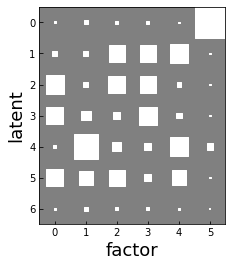

In [24]:
from analysis.hinton import hinton
hinton(vae_R, 'factor', 'latent', fontsize=18)

In [27]:
print(vae_R.shape)

(7, 6)


In [24]:
print(vae_scores.disentanglement_scores)

[0.70315351 0.6942059  0.29207009 0.35471524 0.26990988 0.29582341
 0.27595099]


## new exp 3d-shapes

In [5]:
test_loader = get_dataloaders("dshapes2",
                              batch_size=128,
                              shuffle=False,
                              logger=None)
exp_dir = 'cvae_dshapes2_randSample_klqq=0.1_klu=10_epoch=70_batch=32_z=7_zu=1'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)

In [8]:
l, t = infer(model, test_loader)

In [24]:
from analysis.metrics import DCIMetrics
metric_data = (l[:,:6], t)
eastwood = DCIMetrics(metric_data, n_factors=6)

In [25]:
vae_scores = eastwood(model, model_zs = metric_data)
vae_R = vae_scores.R_coeff

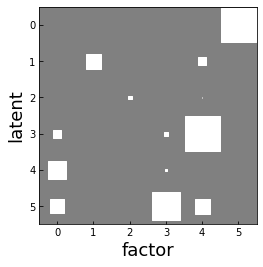

In [26]:
from analysis.hinton import hinton
hinton(vae_R, 'factor', 'latent', fontsize=18)

In [27]:
print(vae_scores.disentanglement_scores)

[1.         0.70023737 0.93821185 0.85113669 0.95553696 0.49920984]


In [28]:
print(vae_scores.overall_disentanglment)

0.7925896979212347


In [16]:
print(vae_R)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.13894131e-01]
 [0.00000000e+00 1.74199145e-01 0.00000000e+00 0.00000000e+00
  5.15097845e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.08848454e-02 0.00000000e+00
  2.60105544e-04 0.00000000e+00]
 [4.81733732e-02 0.00000000e+00 0.00000000e+00 1.38038315e-02
  9.37402693e-01 0.00000000e+00]
 [2.41154866e-01 0.00000000e+00 0.00000000e+00 3.77611552e-03
  0.00000000e+00 0.00000000e+00]
 [1.54128355e-01 0.00000000e+00 0.00000000e+00 5.90074644e-01
  1.71997119e-01 0.00000000e+00]]


## new exp (batch 64)

In [4]:
test_loader = get_dataloaders("dshapes2",
                              batch_size=128,
                              shuffle=False,
                              logger=None)
exp_dir = 'cvae_dshapes2_randSample_klqq=0.1_klu=10_epoch=70_batch=64_z=7_zu=1'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)

In [6]:
l, t = infer(model, test_loader)

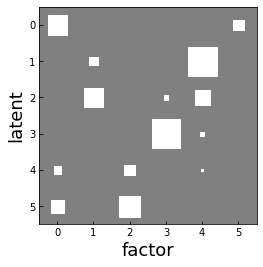

In [7]:
from analysis.metrics import DCIMetrics
metric_data = (l[:,:6], t)
eastwood = DCIMetrics(metric_data, n_factors=6)
vae_scores = eastwood(model, model_zs = metric_data)
vae_R = vae_scores.R_coeff
from analysis.hinton import hinton
hinton(vae_R, 'factor', 'latent', fontsize=18)

## new exp (batch 128)

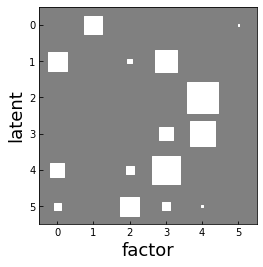

In [9]:
test_loader = get_dataloaders("dshapes2",
                              batch_size=128,
                              shuffle=False,
                              logger=None)
exp_dir = 'cvae_dshapes2_randSample_klqq=0.1_klu=10_epoch=70_z=7_zu=1'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)
l, t = infer(model, test_loader)
from analysis.metrics import DCIMetrics
metric_data = (l[:,:6], t)
eastwood = DCIMetrics(metric_data, n_factors=6)
vae_scores = eastwood(model, model_zs = metric_data)
vae_R = vae_scores.R_coeff
from analysis.hinton import hinton
hinton(vae_R, 'factor', 'latent', fontsize=18)

In [10]:
print(vae_scores.overall_disentanglment)

0.7280441960556944
